# Forecasting
______________________________________________________

### Import Relevant Packages

In [3]:
# Package Importation
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
from datetime import date, timedelta
import requests
import bs4 as bs
import pickle
from os import listdir
from os import environ
import quandl
from math import floor

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tensorflow.keras import Sequential, backend
from tensorflow.keras.layers import Dense, LSTM, Dropout

# GPU Utilization
from tensorflow.python.client import device_lib
environ["CUDA_VISIBLE_DEVICES"] = "-1" # Toggles GPU utilization
print("GPUs: ", device_lib.list_local_devices(), "\n")

'''
# Input functions from other notebook
import import_ipynb
from functions_1 import *
'''

# Import API keys
from API_keys import Quandl_api_key, AlphaVantage_api_key

# Check versions
print('python: {}'.format(sys.version))
print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('pandas_datareader: {}'.format(pdr.__version__))
print('requests: {}'.format(requests.__version__))
print('bs4: {}'.format(bs.__version__))
#print('tensorflow: {}'.format(tf.version.VERSION))
#print('tensorflow: {}'.format(tf.__version__))

%matplotlib inline

# Quandl API Configuration
quandl.ApiConfig.api_key = Quandl_api_key

GPUs:  [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6727108433182472765
] 

python: 3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]
pandas: 0.25.1
numpy: 1.16.5
pandas_datareader: 0.8.1
requests: 2.22.0
bs4: 4.8.0


### Functions to Import Ticker and S&P 500 Price/ Volume Data

In [4]:
# Pull Tickers
def sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker.rstrip('\n'))
        
    with open("Forecasting_Exp_1_Data\sp500_tickers.pickle","wb") as f:
        pickle.dump(tickers,f)
        
    return tickers

def sp500_yahoo(tickers, start, end):
    yahoo_df = pd.DataFrame()
    date_string = '_from_' + str(start) + '_to_' + str(end)

    for i, ticker in enumerate(tickers):
        print("Collecting Yahoo data ", str(i+1), " of ", str(len(tickers)), ": ", ticker)
        try:
            ticker_data = pdr.get_data_yahoo(symbols=ticker, start=start, end=end)
            ticker_data['Ticker'] = ticker
            ticker_data.reset_index(inplace=True,drop=False)
            yahoo_df = yahoo_df.append(ticker_data)

        except:
            print("Exception")
            continue
            
    pickle_save_path = 'Forecasting_Exp_1_Data\sp500_yahoo' + date_string + '.pickle'
    with open(pickle_save_path,"wb") as f:
        pickle.dump(yahoo_df,f)
        
    excel_save_path = 'Forecasting_Exp_1_Data\sp500_yahoo' + date_string + '.xlsx'
    yahoo_df.to_excel(excel_save_path)
    
    return yahoo_df


###  Functions to Import Quandl Data

In [5]:
def get_sentiment(start, end):
    date_string = '_from_' + str(start) + '_to_' + str(end)

    sent_df = pd.DataFrame(quandl.get('AAII/AAII_SENTIMENT', start_date=start, end_date=end))
    sent_df.reset_index(inplace=True,drop=False)

    pickle_save_path = 'Forecasting_Exp_1_Data\sentiment' + date_string + '.pickle'
    with open(pickle_save_path,"wb") as f:
        pickle.dump(sent_df,f)
        
    excel_save_path = 'Forecasting_Exp_1_Data\sentiment' + date_string + '.xlsx'
    sent_df.to_excel(excel_save_path)
        
    return sent_df


### Functions to Update Data Dictionary (Local Datasets)

In [6]:
# Update local datasets
def update_data(start, end, overwrite_all = 0, ticker_subset = None):
    '''
    Input: Dictionary of All Datasets
    Returns: Updated Data, or saved data
    '''
    date_string = '_from_' + str(start) + '_to_' + str(end)

    stored_files = listdir('Forecasting_Exp_1_Data')
    # print("Stored files: ", stored_files)
    
    data_dict = {}
    
    # Add sp500 tickers
    if ('sp500_tickers.pickle' in stored_files) and (overwrite_all == 0):
        print('Loading Tickers from file')
        with open('Forecasting_Exp_1_Data\sp500_tickers.pickle', 'rb') as f:
            data_dict['sp500_tickers'] = pickle.load(f)
    else:
        print('Pulling Tickers from web')
        data_dict['sp500_tickers'] = sp500_tickers()

    # Add yahoo data
    pickle_yahoo_path = "sp500_yahoo" + date_string + ".pickle"
    pickle_yahoo_dir_path = "Forecasting_Exp_1_Data\sp500_yahoo" + date_string + ".pickle"
    if (pickle_yahoo_path in stored_files) and (overwrite_all == 0):
        print('Loading Yahoo price data from file')
        with open(pickle_yahoo_dir_path, 'rb') as f:
            data_dict['sp500_yahoo'] = pickle.load(f)
    else:
        print('Pulling Yahoo price data from web')
        if ticker_subset is None:
            data_dict['sp500_yahoo'] = sp500_yahoo(data_dict['sp500_tickers'], start, end)
        else:
            data_dict['sp500_yahoo'] = sp500_yahoo(ticker_subset, start, end)


    # Add sentiment Data
    pickle_sent_path = "sentiment" + date_string + ".pickle"
    pickle_sent_dir_path = "Forecasting_Exp_1_Data\sentiment" + date_string + ".pickle"
    if (pickle_sent_path in stored_files) and (overwrite_all == 0):
        print('Loading sentiment data from file')
        with open(pickle_sent_dir_path, 'rb') as f:
            data_dict['sentiment'] = pickle.load(f)
    else:
        print('Pulling sentiment data from web')
        data_dict['sentiment'] = get_sentiment(start, end)
        
    return data_dict

### Helper Functions

In [13]:
def splitter_folds(df_series, train_percent, num_folds):
    
    """
    Input: df_series as [type] pandas.core.series.Series
    Input: train_percent as [type] float
    Returns: tuple of fold lists, train lists and test lists
    """
    
    series_length = len(df_series)
    splits = np.linspace(0, series_length, num_folds + 1, endpoint = True, dtype=int)
        
    train_list = []
    test_list = []
    fold_list = []
    
    for index, value in enumerate(splits):
        if index == 0:
            continue
        
        fold = df_series[splits[index-1]:splits[index]]
        fold_list.append(fold)
        fold_len = len(fold)
        train_list.append(fold[:floor(train_percent*fold_len)])
        test_list.append(fold[floor(train_percent*fold_len):])
    
    return(fold_list, train_list, test_list)

def splitter(df, train_percent):
    
    df_length = df.shape[0]
    split_index = floor(train_percent * df_length)
    
    df_train = pd.DataFrame(df[0:split_index])
    df_test = pd.DataFrame(df[split_index:])
    
    
    return (df_train, df_test)
    
def smoother_scaler(train_data, test_data, EMA, gamma):
    
    """
    train_data: [type: pandas DataFrame]
    """
    train_data_sm_sc = pd.DataFrame()
    test_data_sm_sc = pd.DataFrame()
    
    for col in train_data.columns:
        scaler = MinMaxScaler()
        
        train_col = np.asarray(scaler.fit_transform(np.asarray(train_data[col]).reshape(-1, 1)))
        test_col = np.asarray(scaler.transform(np.asarray(test_data[col]).reshape(-1, 1)))
                        
        print("Scaling coef's. for col ", col, ' : ', scaler.scale_)

        for i in range(len(train_col)):
                    EMA = gamma*train_col[i] + (1-gamma)*EMA
                    train_col[i] = EMA
                
        '''
        for j in range(len(test_col)):
                    EMA = gamma*test_col[j] + (1-gamma)*EMA
                    test_col[j] = EMA        
        '''

                    
        train_col = train_col.reshape(-1)
        test_col = test_col.reshape(-1)
                    
        train_data_sm_sc[col] = train_col
        test_data_sm_sc[col] = test_col
     
    return (train_data_sm_sc, test_data_sm_sc)


def ltsm_sequence_generator(train_data, seq_length):
    
    train_data = np.asarray(train_data)
    
    X_train = []
    y_train = []
    for i in range(seq_length, train_data.shape[0]):
        X_train.append(train_data[i-seq_length:i])
        y_train.append(train_data[i, 0])
        
    return (np.asarray(X_train), np.asarray(y_train))

def join_timeseries(df_list, fill_nan_fwd = 0, snip_head = 0):
    
    """
    Join timeseries dataframes
    
    Positional arguments: 
    df_list -- [list] of [DataFrames]: to be joined  
    
    Keyword arguments:
    fill_nan_fwd -- [int]: fill NaN rows in joined dataframe by pulling non-NaN data 
                       forward until next non-NaN entry per column
                       
    snip_head -- [int]: delete (oldest) rows that represent incomplete features
    """
    
    if len(df_list) == 1:
        return df_list[0]
    else:
        df_joined = df_list[0]
        for df in df_list[1:]:
            df_joined = df_joined.merge(df, how='outer', on='Date', sort=True) 
        
        return df_joined

### Neural Network Construction

In [8]:
def build_NN(train_data, batch_size, dropout):

    '''
    Define Model
    '''
    
    regressior = Sequential()
    
    regressior.add(LSTM(units = 80, activation = 'relu', return_sequences = True, input_shape = (train_data.shape[1], train_data.shape[2])))
    regressior.add(Dropout(dropout))
    
    '''
    regressior.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
    regressior.add(Dropout(1.5*dropout))
    
    regressior.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
    regressior.add(Dropout(2*dropout))
    
    regressior.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
    regressior.add(Dropout(1.5*dropout))
    '''

    
    regressior.add(LSTM(units = 120, activation = 'relu'))
    regressior.add(Dropout(dropout))
    
    regressior.add(Dense(units=1))
    
    regressior.summary()
    
    return regressior

def add_Optimizer(model):

    '''
    Optimizer
    '''
    model.compile(optimizer='adam', loss = 'mean_squared_error')
    
    return model

def train_Model(model, X_train, y_train, epochs, batch_size):

    '''
    Train
    '''
    print(X_train.shape, y_train.shape, epochs, batch_size)
    
    backend.clear_session()
    
    history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)
    
    return model, history

def evalulate_performance(model, train_data_raw, test_data_raw, train_data_sm_sc, test_data_sm_sc, seq_length):
    
    '''
    print("Raw training data")
    print(train_data_raw.head())
    print("Raw testing data")
    print(test_data_raw.head())
    '''

    past_x_days = train_data_raw.tail(seq_length)
    df = past_x_days.append(test_data_raw, ignore_index = True)
    
    #df = df.drop(['Date', 'Adj Close', 'Ticker'], axis = 1)

    scaler = MinMaxScaler()
    
    inputs = scaler.fit_transform(df)
    
    X_test = []
    y_test = []
    
    for i in range(seq_length, inputs.shape[0]):
        X_test.append(inputs[i-seq_length:i])
        y_test.append(inputs[i, 0])
        
    X_test, y_test = np.array(X_test), np.array(y_test)
    
    y_pred = model.predict(X_test)
    
    scale_arr = scaler.scale_
    min_arr = scaler.data_min_
    
    y_pred /= scale_arr[3] 
    y_pred += min_arr[3]
    
    y_test /= scale_arr[3]
    y_test += min_arr[3]
    
    #print("Shape of y_pred", y_pred.shape)
    #print("y_pred")
    #print(y_pred)
        
    print("Shape of y_testd", y_test.shape)
    print("y_test")
    print(y_test)
    
    # Visualising the results
    plt.figure(figsize=(14,5))
    plt.plot(y_test, color = 'red', label = 'Real')
    plt.plot(y_pred, color = 'blue', label = 'Predicted')
    plt.title('Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    
    return y_pred


def save_model(model, filepath):
    model.save(
    filepath,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

def evaluate_model_AA001_day_ahead(y_pred, y_test, y_train, trade_percentage):
        
    y_pred = list(y_pred)
    y_test = list(y_test)
    y_train = list(y_train)

    '''
    - For each day, trade [trade_percentage] of initial capital
    - Given a day's predicted close price, if it is above the previous day's close price (current day open price),
      buy a position worth [trade_percentage] % of the current portfolio value 
      
    - Plot single day and cumulative percentage returns vs time
    
    '''
    
    # y_pred start at day 0 of test
    # y_test starts at day -1 of test (last day of train)
    # cumulative_percentages represents time series of portfolio value wrt trade_percentage
    # single_day_percentages, single_day_pred_changes are raw changes
    
    single_day_percentages = []
    single_day_pred_changes = []
    cumulative_percentages = [1]
    
    initial_capital = 1
    sum_percent_trading_error = 0
    
    # Add last value of training set to 
    y_test = np.insert(y_test, 0, y_train[-1:], axis=0)
    
    for i, pred in enumerate(y_pred):
        single_day_pred_changes.append((pred - y_test[i]) / y_test[i])

        if pred > y_test[i]: # Predicting that the stock will go 'up'
            single_day_change = np.float64((y_test[i + 1] - y_test[i]) / y_test[i]) 
            predicted_change = np.float64((pred - y_test[i]) / y_test[i])
                    
            single_day_percentages.append(single_day_change)
            cumulative_percentages.append(cumulative_percentages[i]*(1 + (single_day_change)*(trade_percentage)))
                        
            sum_percent_trading_error += abs(single_day_change - predicted_change)
            
        else:
            single_day_percentages.append(0)
            cumulative_percentages.append(cumulative_percentages[i])
            
            
    sum_percent_trading_error /= len(y_pred)
    
    cumulative_percentages = cumulative_percentages[1:]
    
    fig, axs = plt.subplots(figsize=(14,5))
    
    axs.plot(single_day_percentages, c = 'tab:orange')
    axs.plot(single_day_pred_changes, c = 'tab:red')
    axs1 = axs.twinx() 
    axs1.plot(cumulative_percentages, c = 'tab:blue')
    
    return single_day_percentages, single_day_pred_changes, cumulative_percentages, sum_percent_trading_error


### Commands to Collect Data

In [9]:
# Date information
today = date.today()
year_ago = today - timedelta(days=365)
AAL_max = date(2005,9,27)
# Pull Stock Data
print("Pulling data from ", AAL_max, " to ", today)

data_dict = update_data(start=AAL_max, end=today, overwrite_all = 1, ticker_subset = ['AAL'])


Pulling data from  2005-09-27  to  2019-12-30
Pulling Tickers from web
Pulling Yahoo price data from web
Pulling sentiment data from web


### Collect Individual DataFrames

In [10]:
AAL_df = data_dict["sp500_yahoo"].loc[data_dict["sp500_yahoo"]['Ticker'] == 'AAL']
AAL_df.reset_index(inplace=True, drop=True)

print('AAL_df columns: ')
print(AAL_df.columns)
print("")

sent_df = data_dict["sentiment"]
sent_df.reset_index(inplace=True, drop=True)

print('sent_df columns: ')
print(sent_df.columns)
print("")

AAL_df columns: 
Index(['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close',
       'Ticker'],
      dtype='object')

sent_df columns: 
Index(['Date', 'Bullish', 'Neutral', 'Bearish', 'Total',
       'Bullish 8-Week Mov Avg', 'Bull-Bear Spread', 'Bullish Average',
       'Bullish Average + St. Dev', 'Bullish Average - St. Dev',
       'S&P 500 Weekly High', 'S&P 500 Weekly Low', 'S&P 500 Weekly Close'],
      dtype='object')



### Join DataFrames

In [14]:
joined_df = join_timeseries([AAL_df, sent_df])
joined_df.to_excel(r'C:\Users\Mark\Documents\Trading_Notebooks\Forecasting_Exp_1_Data\temp\joined_df.xlsx')

datetime64[ns] datetime64[ns]


Scaling coef's. for col  High  :  [0.0163292]
Scaling coef's. for col  Low  :  [0.01651528]
Scaling coef's. for col  Open  :  [0.01642306]
Scaling coef's. for col  Close  :  [0.01634254]
Scaling coef's. for col  Volume  :  [7.26592637e-09]


C:\Users\Mark\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

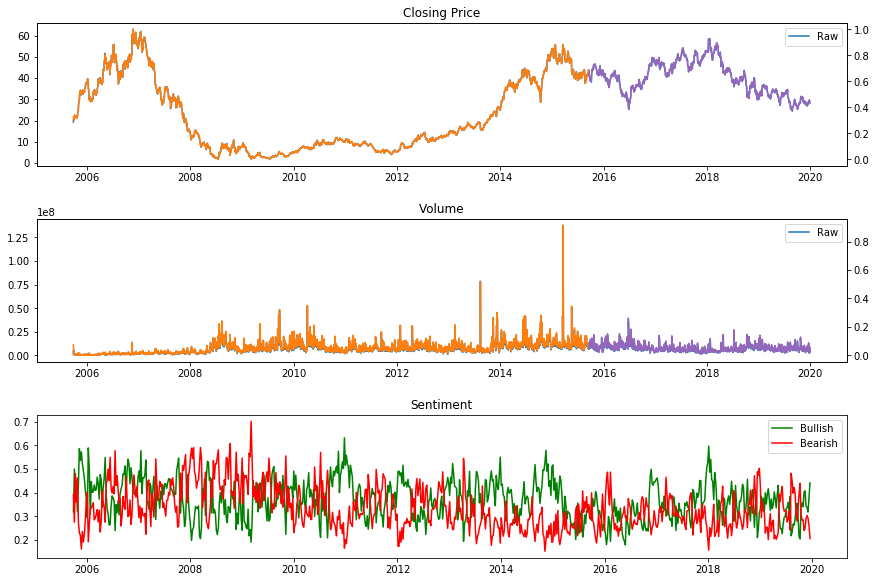

In [11]:

'''
Hyperparameter Definition
'''
EMA = 0.0
gamma = 0.9
''''''

AAL_df_train, AAL_df_test = splitter(AAL_df, 0.7)

AAL_df_train_ex = pd.DataFrame({'Date': AAL_df_train['Date'], 'Adj Close': AAL_df_train['Adj Close'], 'Ticker': AAL_df_train['Ticker']})
AAL_df_train = AAL_df_train.drop(['index', 'Date', 'Adj Close', 'Ticker'], axis = 1)

AAL_df_test_ex = pd.DataFrame({'Date': AAL_df_test['Date'], 'Adj Close': AAL_df_test['Adj Close'], 'Ticker': AAL_df_test['Ticker']})

AAL_df_test = AAL_df_test.drop(['index', 'Date', 'Adj Close', 'Ticker'], axis = 1)

AAL_df_train_sm_sc, AAL_df_test_sm_sc = smoother_scaler(AAL_df_train, AAL_df_test, EMA, gamma)


for col in AAL_df_train_ex.columns:
    AAL_df_train_sm_sc[col] = AAL_df_train_ex[col].values
    
for col in AAL_df_test_ex.columns:
    AAL_df_test_sm_sc[col] = AAL_df_test_ex[col].values

plt.figure(1)
fig, axs = plt.subplots(3, 1, figsize=(12,8))

axs[0].plot(AAL_df['Date'], AAL_df['Close'], label = "Raw", c = 'tab:blue')
axs01 = axs[0].twinx()  
axs01.plot(AAL_df_train_sm_sc['Date'], AAL_df_train_sm_sc['Close'], label = "Smoothed", c = 'tab:orange')
axs01.plot(AAL_df_test_sm_sc['Date'], AAL_df_test_sm_sc['Close'], label = "Smoothed", c = 'tab:purple')

axs[1].plot(AAL_df['Date'], AAL_df['Volume'], label = "Raw", c = 'tab:blue')
axs11 = axs[1].twinx()
axs11.plot(AAL_df_train_sm_sc['Date'], AAL_df_train_sm_sc['Volume'], label = "Smoothed", c = 'tab:orange')
axs11.plot(AAL_df_test_sm_sc['Date'], AAL_df_test_sm_sc['Volume'], label = "Smoothed", c = 'tab:purple')

axs[2].plot(sent_df['Date'], sent_df['Bullish'], label = "Bullish", color='g')
axs[2].plot(sent_df['Date'], sent_df['Bearish'], label = "Bearish", color='r')

axs[0].set_title("Closing Price")
axs[1].set_title("Volume")
axs[2].set_title("Sentiment")

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)

axs[0].legend()
axs[1].legend()
axs[2].legend()



### Preparing to Run NN

In [18]:
'''
Hyperparameter Definition
'''

batch_size = 10 # Standard batch size
dropout = 0.1
epochs = 15
seq_length = 60
''''''

'''
Format Data to Feed to NN
'''

AAL_data_training = AAL_df_train_sm_sc.drop(['Date', 'Adj Close', 'Ticker'], axis = 1)
AAL_data_testing = AAL_df_test_sm_sc.drop(['Date', 'Adj Close', 'Ticker'], axis = 1)

X_train, y_train = ltsm_sequence_generator(AAL_data_training, seq_length)



### Model Building

In [19]:
model = build_NN(X_train, batch_size, dropout)
model = add_Optimizer(model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 240, 80)           27520     
_________________________________________________________________
dropout (Dropout)            (None, 240, 80)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 120)               96480     
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 121       
Total params: 124,121
Trainable params: 124,121
Non-trainable params: 0
_________________________________________________________________


### Model Training

(2271, 240, 5) (2271,) 15 10
Train on 2271 samples
Epoch 1/15
2271/2271 [==============================] - 63s 28ms/sample - loss: 0.0046
Epoch 2/15
2271/2271 [==============================] - 64s 28ms/sample - loss: 0.0016
Epoch 3/15
2271/2271 [==============================] - 63s 28ms/sample - loss: 0.0015
Epoch 4/15
2271/2271 [==============================] - 63s 28ms/sample - loss: 0.0012
Epoch 5/15
2271/2271 [==============================] - 62s 27ms/sample - loss: 0.0012
Epoch 6/15
2271/2271 [==============================] - 62s 27ms/sample - loss: 0.0011
Epoch 7/15
2271/2271 [==============================] - 62s 27ms/sample - loss: 0.0011
Epoch 8/15
2271/2271 [==============================] - 62s 27ms/sample - loss: 0.0012
Epoch 9/15
2271/2271 [==============================] - 68s 30ms/sample - loss: 8.9705e-04
Epoch 10/15
2271/2271 [==============================] - 62s 27ms/sample - loss: 9.3567e-04
Epoch 11/15
2271/2271 [==============================] - 61s 27ms/samp

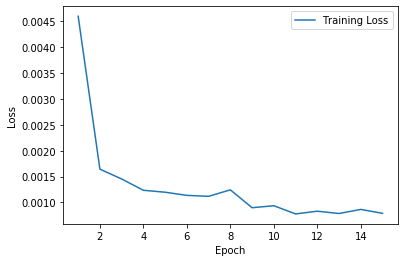

In [20]:
model, history = train_Model(model, X_train, y_train, epochs, batch_size)

# Get training and test loss histories
training_loss = history.history['loss']
#test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss)
#plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

### Save Model

In [21]:
save_dir = r'C:\Users\Mark\Documents\Trading_Documentation\Models_Saved'
model_name = r'\A00x'
save_path = save_dir + model_name

save_model(model, save_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: C:\Users\Mark\Documents\Trading_Documentation\Models_Saved\A005\assets


### Model Evaluation

Shape of y_testd (1077,)
y_test
[43.29510243 43.27493599 42.33722172 ... 28.57394268 28.85626509
 28.95709534]


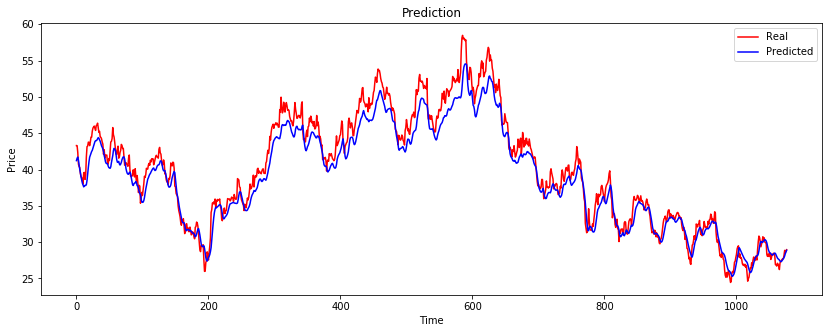

In [22]:
close_pred = evalulate_performance(model, AAL_df_train, AAL_df_test, AAL_data_training, AAL_data_testing, seq_length)

<IPython.core.display.Javascript object>


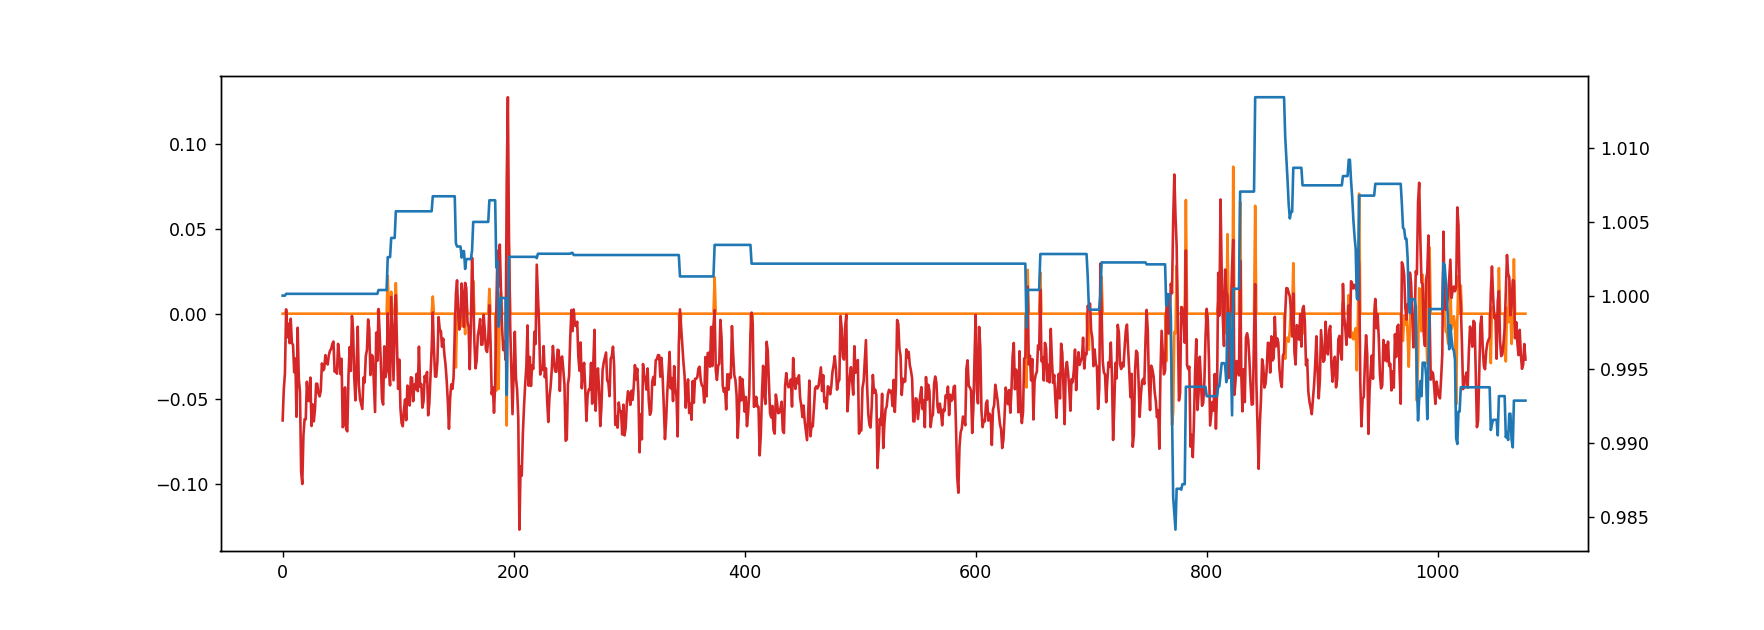

sum_percent_trading_error:  0.0033049739530273173


In [26]:
%matplotlib nbagg

single_day_percentages, single_day_pred_changes, cumulative_percentages, sum_percent_trading_error = evaluate_model_AA001_day_ahead(close_pred, AAL_df_test['Close'].values, AAL_df_train['Close'].values, 0.1)

print("sum_percent_trading_error: ", sum_percent_trading_error)